<a href="https://colab.research.google.com/github/SarahGraceMaclean/GAN-Induration-image-generation/blob/master/Induration_Image_Generation_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir("drive/My Drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


FileNotFoundError: ignored

In [0]:
# Importing the libraries and setting variables 
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable

import matplotlib.pyplot as plt


batchSize = 25 

In [0]:
#Get data, pre-process data, load data

def new_data():
    compose = transforms.Compose(
        [transforms.Resize((64,64)),
         transforms.ToTensor(),         
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    out_dir = '150 Positive'
    return dset.ImageFolder(root=out_dir, transform=compose)
  
dataset = new_data()

dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle = True) # We use dataLoader to get the images of the training set batch by batch. Check that batch size and number of samples/images are evenly dividable. If tehy are not, the last batch will have a smaller number of samples (the left over ones) Avoid this by: drop_last = True

In [0]:
#Initialise Weights

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [0]:
#Generator 

class G(nn.Module):

    def __init__(self):
        super(G, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias = False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace = True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace = True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace = True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias = False),
            nn.Tanh()
        )

    def forward(self, input):
        output = self.main(input)
        return output

netG = G()
netG.apply(weights_init)

G(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4

In [0]:
#Discriminator

class D(nn.Module):

    def __init__(self):
        super(D, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(64, 128, 4, 2, 1, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(128, 256, 4, 2, 1, bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(256, 512, 4, 2, 1, bias = False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(512, 1, 4, 1, 0, bias = False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1)

netD = D()
netD.apply(weights_init)

criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr = 0.0002, betas = (0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = 0.0002, betas = (0.5, 0.999))

mkdir: cannot create directory ‘results_final’: File exists
[0/30][5/6] Loss_D: 0.1766 Loss_G: 6.4043
[1/30][5/6] Loss_D: 0.0688 Loss_G: 7.2831
[2/30][5/6] Loss_D: 0.0451 Loss_G: 8.3568
[3/30][5/6] Loss_D: 0.0839 Loss_G: 6.4408
[4/30][5/6] Loss_D: 0.0177 Loss_G: 14.4864
[5/30][5/6] Loss_D: 0.0214 Loss_G: 14.6050
[6/30][5/6] Loss_D: 0.0005 Loss_G: 13.7684
[7/30][5/6] Loss_D: 0.0696 Loss_G: 11.7411
[8/30][5/6] Loss_D: 0.0296 Loss_G: 8.6283
[9/30][5/6] Loss_D: 0.0115 Loss_G: 8.8113
[10/30][5/6] Loss_D: 0.0007 Loss_G: 14.2782
[11/30][5/6] Loss_D: 2.4529 Loss_G: 42.4104
[12/30][5/6] Loss_D: 0.0000 Loss_G: 44.5141
[13/30][5/6] Loss_D: 0.0000 Loss_G: 44.4739
[14/30][5/6] Loss_D: 0.0000 Loss_G: 44.2903
[15/30][5/6] Loss_D: 0.0000 Loss_G: 44.5048
[16/30][5/6] Loss_D: 0.0000 Loss_G: 44.3937
[17/30][5/6] Loss_D: 0.0000 Loss_G: 44.2306
[18/30][5/6] Loss_D: 0.0000 Loss_G: 44.5246
[19/30][5/6] Loss_D: 0.0000 Loss_G: 44.4595
[20/30][5/6] Loss_D: 0.0000 Loss_G: 44.5252
[21/30][5/6] Loss_D: 0.0000 Loss

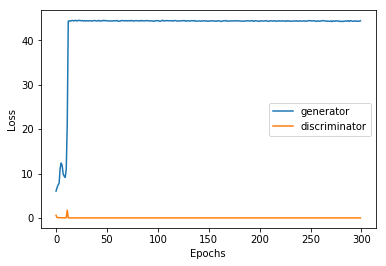

In [0]:
# train

!mkdir results_final

gen_loss_avg = []
disc_loss_avg = []


for epoch in range(300):
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0
  
    for i, data in enumerate(dataloader, 0):
        
        netD.zero_grad()
        
        real, _ = data
        input = Variable(real)
        target = Variable(torch.ones(input.size()[0]))
        output = netD(input)
        errD_real = criterion(output, target)
        
        noise = Variable(torch.randn(input.size()[0], 100, 1, 1))
        fake = netG(noise)
        target = Variable(torch.zeros(input.size()[0]))
        output = netD(fake.detach())
        errD_fake = criterion(output, target)
        
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()

        netG.zero_grad()
        target = Variable(torch.ones(input.size()[0]))
        output = netD(fake)
        errG = criterion(output, target)
        errG.backward()
        optimizerG.step()
        
        gen_loss_avg[-1] += errG.item()
        disc_loss_avg[-1] += errD.item()
        num_batches += 1
        
    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches

    print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' % (epoch, 30, i, len(dataloader), errD.item(), errG.item()))       


    if i % 100 == 0:
        vutils.save_image(real, '%s/real_samples(7 B25 E300 positive).png' % "./results_final", normalize = True)
        fake = netG(noise)
vutils.save_image(fake.data, '%s/fake_samples_epoch_%03d(7 B25 E300 positive).png' % ("./results_final", epoch), normalize = True)

plt.ion()

fig = plt.figure()
plt.plot(gen_loss_avg, label='generator')
plt.plot(disc_loss_avg, label='discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [0]:
plt.ion()

fig = plt.figure()
plt.plot(gen_loss_avg[0:299], label='generator')
plt.plot(disc_loss_avg[0:299], label='discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()